![Who's that abalone?](maxresdefault.png)

# Is it possible to estimate the age of an abalone?

## 📖 Background
Japan has a developed seafood market and farming abalones is a significant part of it. For operational and environmental reasons, it is an important consideration to estimate the age of the abalones when they go to market. 

Determining an abalone's age involves counting the number of rings in a cross-section of the shell through a microscope. Since this method is somewhat cumbersome and complex, you are interested in helping the farmers estimate the age of the abalone using its physical characteristics.

It is crucial for the analysis design to decide whether to attempt predicting the age of a live abalone or to use all of its given characteristics as a unit prepared for seafood market. In this take we would focus on predictions based on all of the data, but age prediction based only from the measures obtained of a live abalone could be a promising future study.

## 💾 The data
The dataset was made from the following historical data ([source](https://archive.ics.uci.edu/ml/datasets/abalone)):

#### Abalone characteristics
|    | Variable     | Explanation                                       |
|---:|:-------------|:--------------------------------------------------|
|  0 | `sex`        | M, F, and I (infant)                              |
|  1 | `length`     | longest shell measurement                         |
|  2 | `diameter`   | perpendicular to the length                       |
|  3 | `height`     | measured with meat in the shell                   |
|  4 | `whole_wt`   | whole abalone weight                              |
|  5 | `shucked_wt` | the weight of abalone meat                        |
|  6 | `viscera_wt` | gut-weight                                        |
|  7 | `shell_wt`   | the weight of the dried shell                     |
|  8 | `rings`      | number of rings in a shell cross-section          |
|  9 | `age`        | the age of the abalone: the number of rings + 1.5 |


***Acknowledgments**: Warwick J Nash, Tracy L Sellers, Simon R Talbot, Andrew J Cawthorn, and Wes B Ford (1994) "The Population Biology of Abalone (_Haliotis_ species) in Tasmania. I. Blacklip Abalone (_H. rubra_) from the North Coast and Islands of Bass Strait", Sea Fisheries Division, Technical Report No. 48 (ISSN 1034-3288).*

#### Imports and settings

In [1]:
%%capture

pip install synthia pyvinecopulib tensorflow seaborn

In [2]:
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import synthia as syn
import pyvinecopulib as pv

print(sns.__version__)

0.12.1


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Make NumPy and pandas printouts easier to read
%matplotlib inline
rc_params = {**axes_style('whitegrid'),
             'legend.markerscale': 3,
             'grid.linestyle': ':', 
             'axes.spines.top': False,
             'axes.spines.right':  False}
mpl.rcParams.update(rc_params)
cmap = mpl.cm.get_cmap('plasma')
np.set_printoptions(precision=2, suppress=True)
pd.set_option('display.precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Concatenate, 
                                     Embedding, Flatten, Normalization)
from tensorflow.keras.utils import to_categorical

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

#### Read and process the dataset

In [6]:
abalone = pd.read_csv('./data/abalone.csv', 
                      dtype={'sex': 'category'})

In [7]:
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   sex         4177 non-null   category
 1   length      4177 non-null   float64 
 2   diameter    4177 non-null   float64 
 3   height      4177 non-null   float64 
 4   whole_wt    4177 non-null   float64 
 5   shucked_wt  4177 non-null   float64 
 6   viscera_wt  4177 non-null   float64 
 7   shell_wt    4177 non-null   float64 
 8   rings       4177 non-null   int64   
 9   age         4177 non-null   float64 
dtypes: category(1), float64(8), int64(1)
memory usage: 298.0 KB


In [8]:
abalone.sample(n=10)

sex  length  diameter  height  whole_wt  shucked_wt  viscera_wt  \
1034   F    0.66      0.46    0.16      1.49        0.69        0.33   
1539   I    0.35      0.26    0.09      0.20        0.07        0.05   
4057   F    0.69      0.54    0.18      1.83        0.80        0.41   
3845   M    0.46      0.35    0.10      0.42        0.16        0.10   
2802   M    0.65      0.52    0.15      1.37        0.62        0.29   
777    M    0.49      0.38    0.14      0.64        0.23        0.14   
2432   F    0.61      0.48    0.17      1.09        0.43        0.23   
808    F    0.44      0.34    0.13      0.42        0.15        0.12   
3954   M    0.48      0.39    0.10      0.56        0.30        0.10   
972    F    0.53      0.41    0.14      0.72        0.35        0.17   

      shell_wt  rings   age  
1034      0.18      9 10.50  
1539      0.06      7  8.50  
4057      0.50     11 12.50  
3845      0.14     11 12.50  
2802      0.36      9 10.50  
777       0.20     13 14.50  
2432      0.38     11 12.50  
808       0.13     10 11.50  
3954      0.13      7  8.50  
972       0.17      8  9.50

## Data exploration

In [9]:

abalone.describe().T

count  mean  std  min  25%   50%   75%   max
length     4177.00  0.52 0.12 0.07 0.45  0.55  0.61  0.81
diameter   4177.00  0.41 0.10 0.06 0.35  0.42  0.48  0.65
height     4177.00  0.14 0.04 0.00 0.12  0.14  0.17  1.13
whole_wt   4177.00  0.83 0.49 0.00 0.44  0.80  1.15  2.83
shucked_wt 4177.00  0.36 0.22 0.00 0.19  0.34  0.50  1.49
viscera_wt 4177.00  0.18 0.11 0.00 0.09  0.17  0.25  0.76
shell_wt   4177.00  0.24 0.14 0.00 0.13  0.23  0.33  1.00
rings      4177.00  9.93 3.22 1.00 8.00  9.00 11.00 29.00
age        4177.00 11.43 3.22 2.50 9.50 10.50 12.50 30.50

In [10]:
sns.countplot(data=abalone,
              x='sex',
              palette='plasma')
plt.show()

We can see `sex` being rather evenly distributed with males being most common.

In [11]:

for _ in range(1000):
    sns.kdeplot(x='age',
                hue='sex',
                data=abalone.sample(frac=0.05,
                                    replace=True),
                palette='plasma',
                alpha=0.05)

Bootstrapping the `age` feature has shown that `Infant` abalones consistently have age around 9 years while `Adult` abalones tend to have 12 years most commonly.

In [12]:

sns.histplot(data=abalone,
             x='whole_wt',
             hue='sex',
             #hue_order=['I', 'F', 'M'],
             palette={'F':cmap(0.25), 'I':cmap(0.5), 'M':cmap(0.75)},
             multiple='stack')
plt.show()

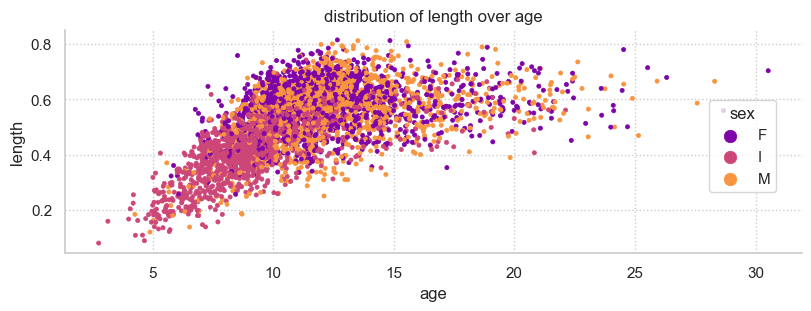

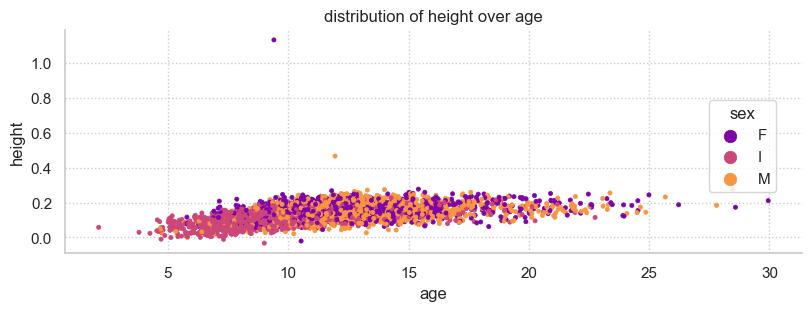

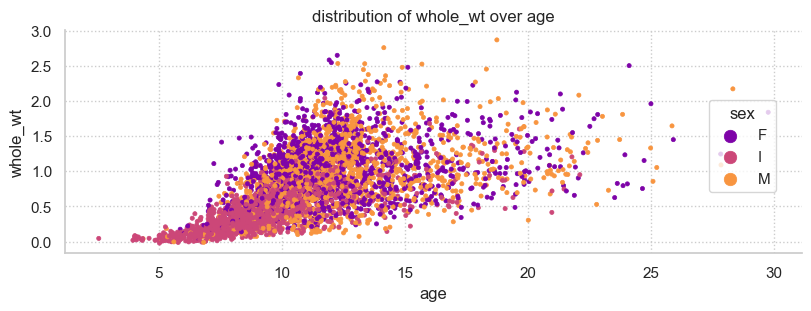

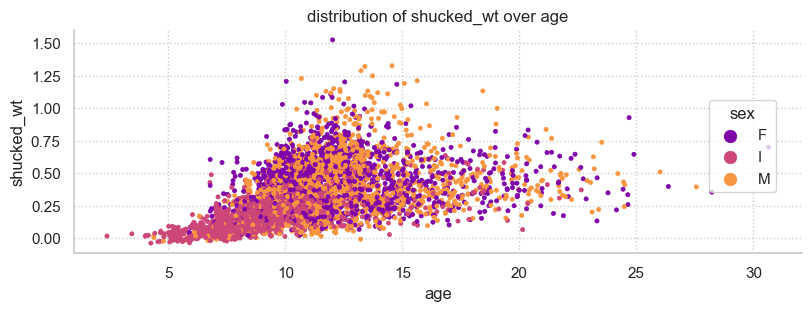

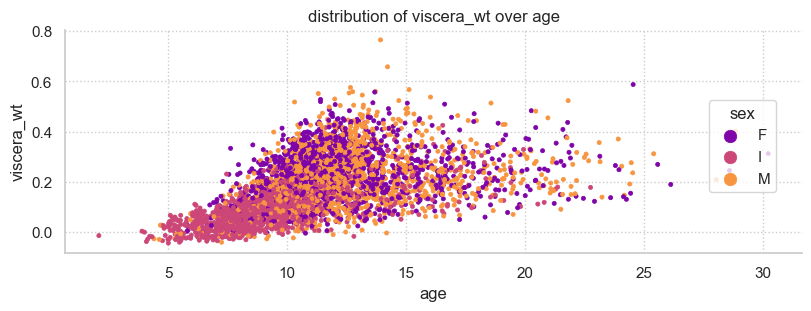

In [20]:
for feature in ['length', 'diameter', 'height', 'whole_wt',
                'shucked_wt', 'viscera_wt', 'shell_wt']:
    (so.Plot(abalone, 
             x='age',
             y=feature,
             color='sex')
     .layout(size=(8, 3), engine='constrained')
     .theme(rc_params)
     .add(so.Dot(alpha=1.0,
                 pointsize=3),
          so.Dodge(),
          so.Jitter(x=1, 
                    y=0.1),
          legend=True)
     .label(title=f'distribution of {feature} over age')
     .scale(color=so.Nominal('plasma',
                             order=['F', 'I', 'M']))
     .show())

In [104]:
(so.Plot(abalone, 
         x='age', 
         color='sex')
   .theme(rc_params)
   .pair(y=['length', 'diameter', 'height', 'whole_wt', 
            'shucked_wt', 'viscera_wt', 'shell_wt'], 
         wrap=7)
   .layout(size=(8, 16), engine='constrained')
   .share(x=True)
   .limit(y0=[-0.1, 1],
          y1=[-0.1, 1], 
          y2=[-0.15, 1.5],
          y3=[-0.3, 3],
          y4=[-0.2, 2], 
          y5=[-0.1, 1],
          y6=[-0.1, 1])
   .add(so.Dot(alpha=1.0,
               pointsize=3),
        so.Dodge(),
        so.Jitter(x=1, 
                  y=0.1),
        legend=True)
   .scale(color=so.Nominal('plasma', 
                           order=['F', 'I', 'M'])))

As we can see when plotting physical features against `age`, the feature `height` contains several outliers, dropping which should benefit for prediction model.

In [105]:
abalone = abalone[abalone.height < abalone.height.quantile(0.999)
                 ].reset_index(drop=True)

Next step is to find correlations between the variables using pandas's `.corr()` method and seaborn's `.heatmap()`

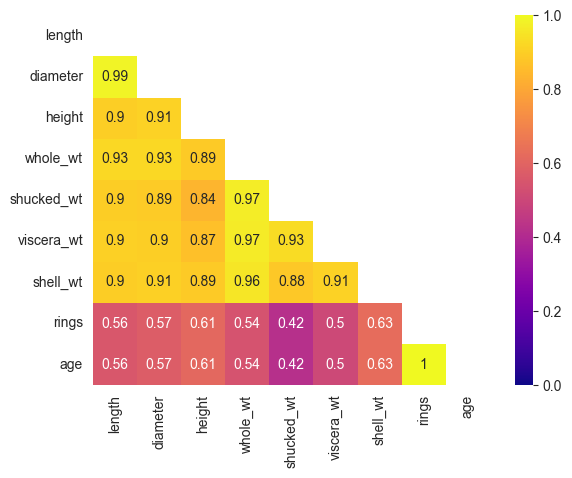

In [106]:
corr = abalone.corr()
mask = np.triu(corr)
f = mpl.figure.Figure(figsize=(8, 5))
ax = f.add_subplot()
g = sns.heatmap(corr, 
                annot=True, 
                mask=mask, 
                vmin=0, 
                vmax=1, 
                cmap='plasma')
plt.show()

The correlation matrix shows how highly related the spatial parameters of an abalone are. `age` and `rings` features are perfectly correlated since the former was calculated by adding 1.5 to the latter. The `height` feature is slightly higher positively correlated to both `age` and `rings`. `shucked_wt` is least correlated to `age` and `rings`, meaning that, in reality, the more abalone meat alone weighs doesn't necessarily mean the older an abalone is. On the contrary, `shell_wt` correlated to `age` and `rings` the highest, meaning it is most likely that an abalone shell gets heavier with years.

## How does weight change with age for each of the three sex categories?

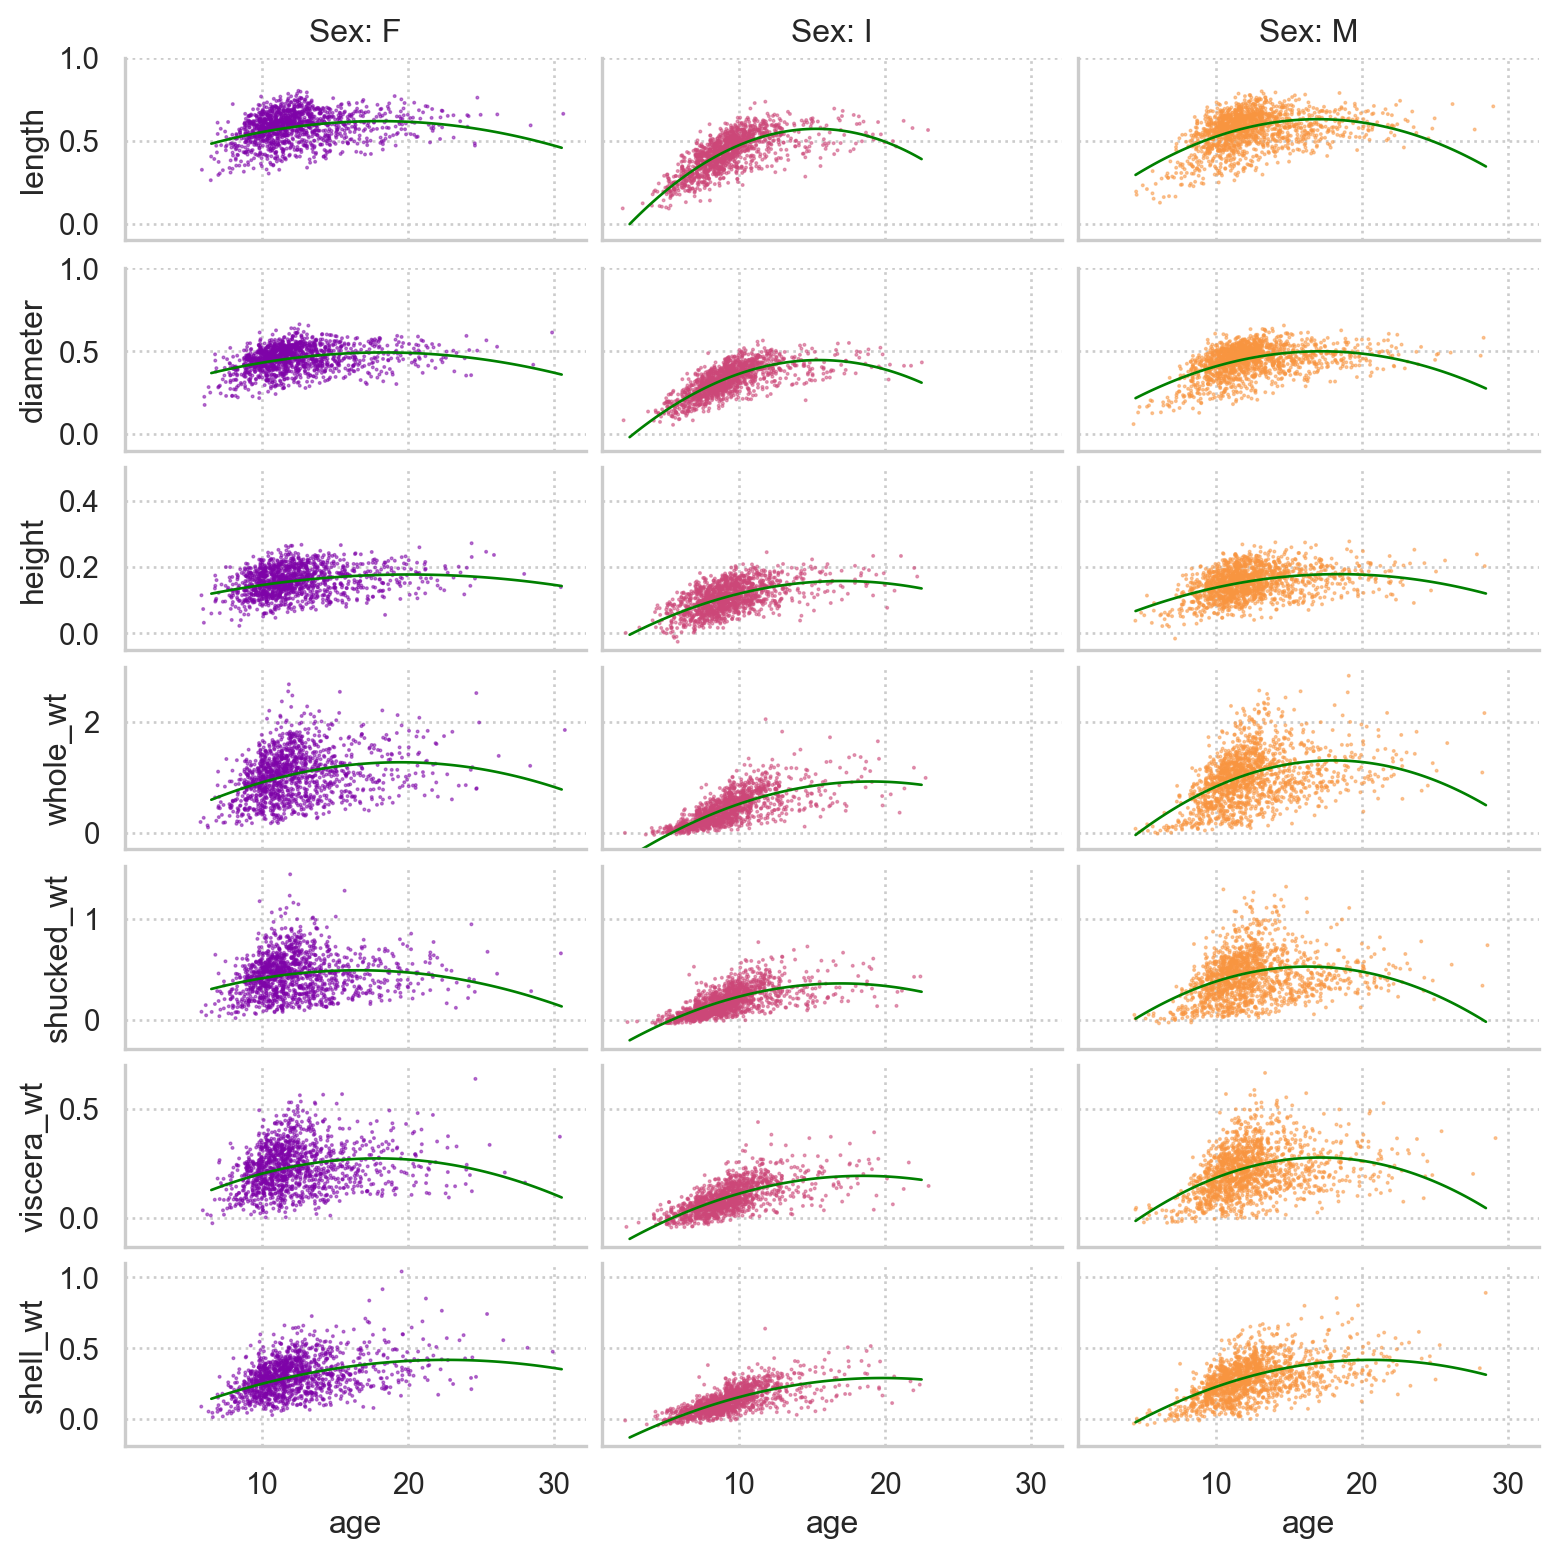

In [107]:

(so.Plot(abalone, 
         x='age', 
         color='sex')
   .theme(rc_params)
   .pair(y=['length', 'diameter', 'height', 'whole_wt', 
            
'shucked_wt', 'viscera_wt', 'shell_wt'])
   .facet(col='sex')
   .layout(size=(8, 8), engine='constrained')
   .share(x=True)
   .limit(y0=[-0.1, 1],
          y1=[-0.1, 1], 
          y2=[-0.05, 0.5],
          y3=[-0.3, 3])
   .add(so.Dot(alpha=0.5,
               pointsize=1),
        so.Dodge(),
        so.Jitter(x=1, 
                  y=0.1),
        legend=False)
   .add(so.Line(color='green',
                linewidth=1),
        so.PolyFit(),
        legend=False)
   .scale(color=so.Nominal('plasma', order=['F', 'I', 'M']))
   .label(col='Sex:')
)

On this grid of scatter plots we may see how differrent `weights` and other physical characteristics change with age and between `sex` categories. `Infants` tend to gain weight when growing (higher `age`) though their `weight` values cluster around the lowest values within population. Adult abalones, both `Male` and `Female`, show their peaking weight around 10 to 15 years with older specimen tend to have less weight. This could be explained that weighty abalones are sent to market earlier while smaller being left to grow.

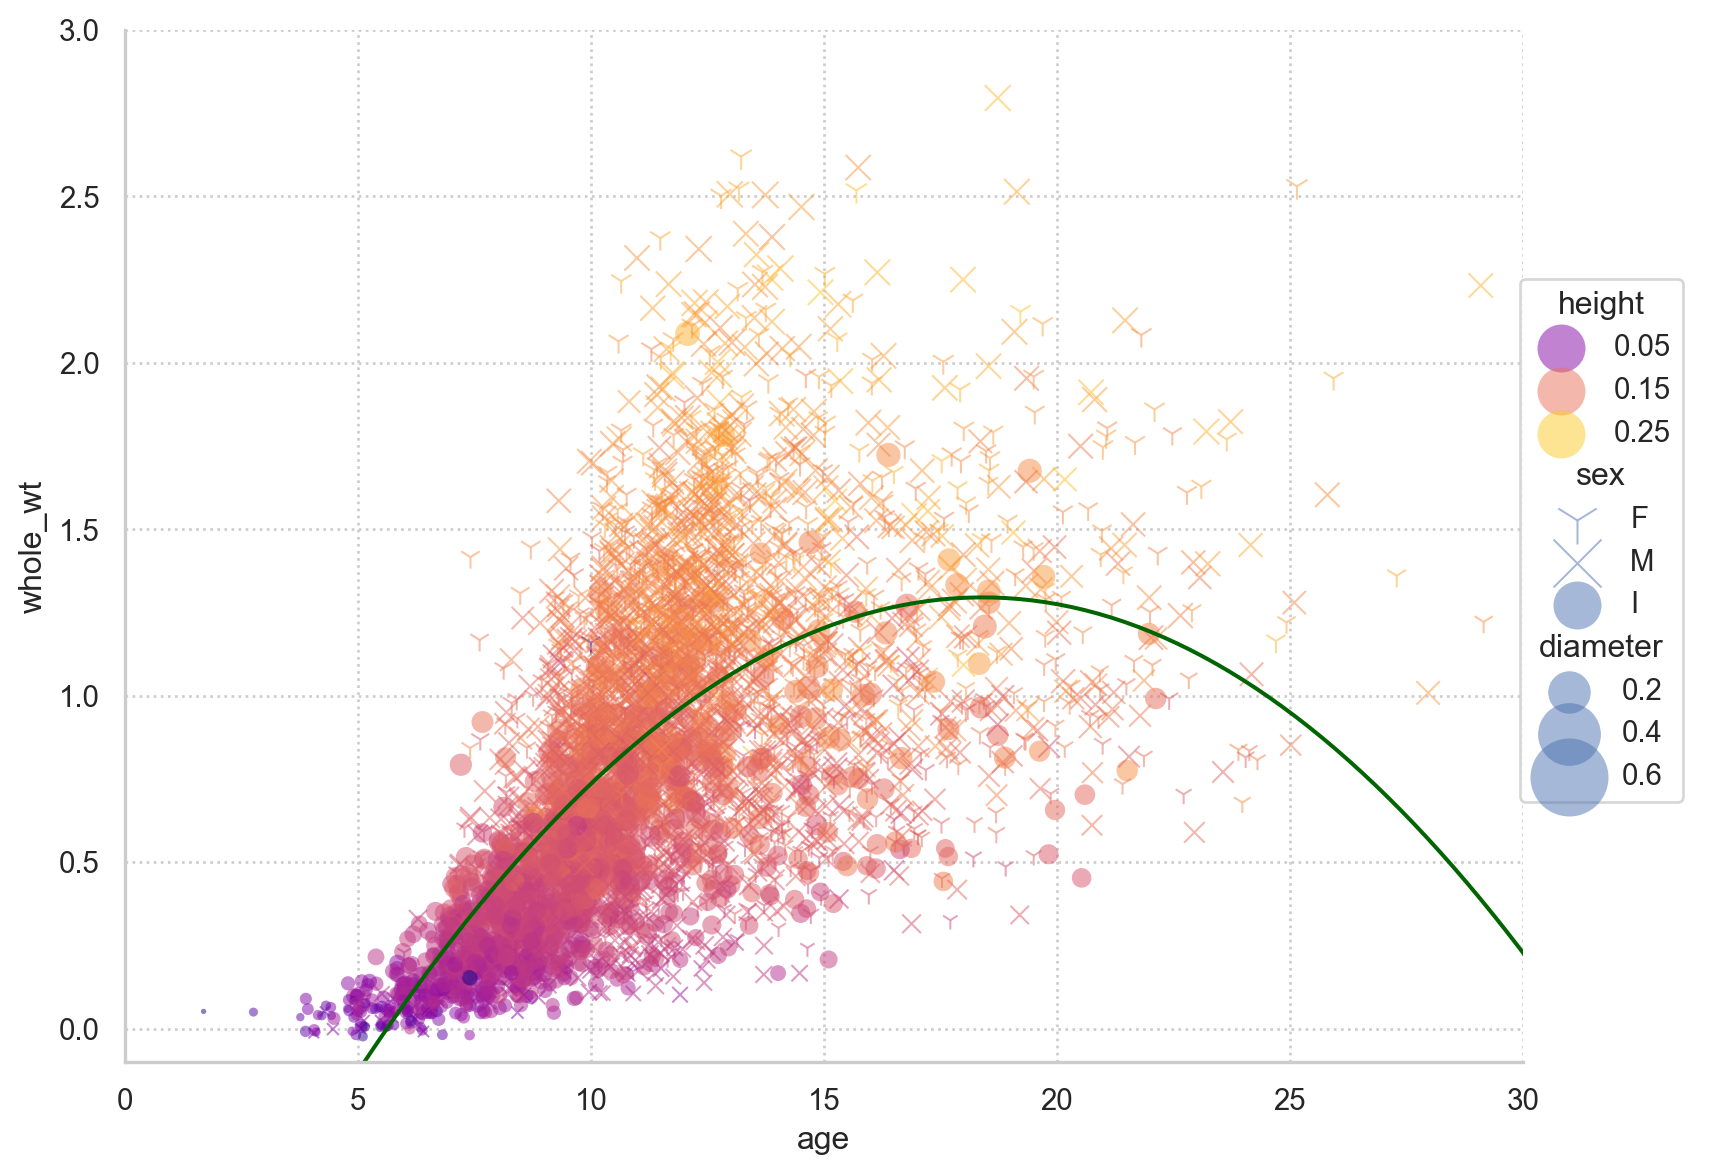

In [108]:
(so.Plot(abalone, 
         x='age', 
         y='whole_wt')
   .theme(rc_params)
   .layout(size=(8, 6), 
           engine='constrained')
   .add(so.Dot(alpha=0.5,
               edgewidth=0),
        so.Dodge(),
        so.Jitter(x=1, 
                  y=0.1),
        color='height',
        marker='sex',
        pointsize='diameter')
   .add(so.Line(color='darkgreen'),
        so.PolyFit())
   .scale(color=so.Continuous('plasma', 
                              norm=(0.01, 0.3), 
                              trans='sqrt'
                             ).tick(at=[0.05, 0.15, 0.25]),
          marker=so.Nominal(['1', 'x', 'o'],
                            order=['F', 'M', 'I']),
          pointsize=(2, 10))
   .limit(x=[0, 30],
          y=[-0.1, 3]))

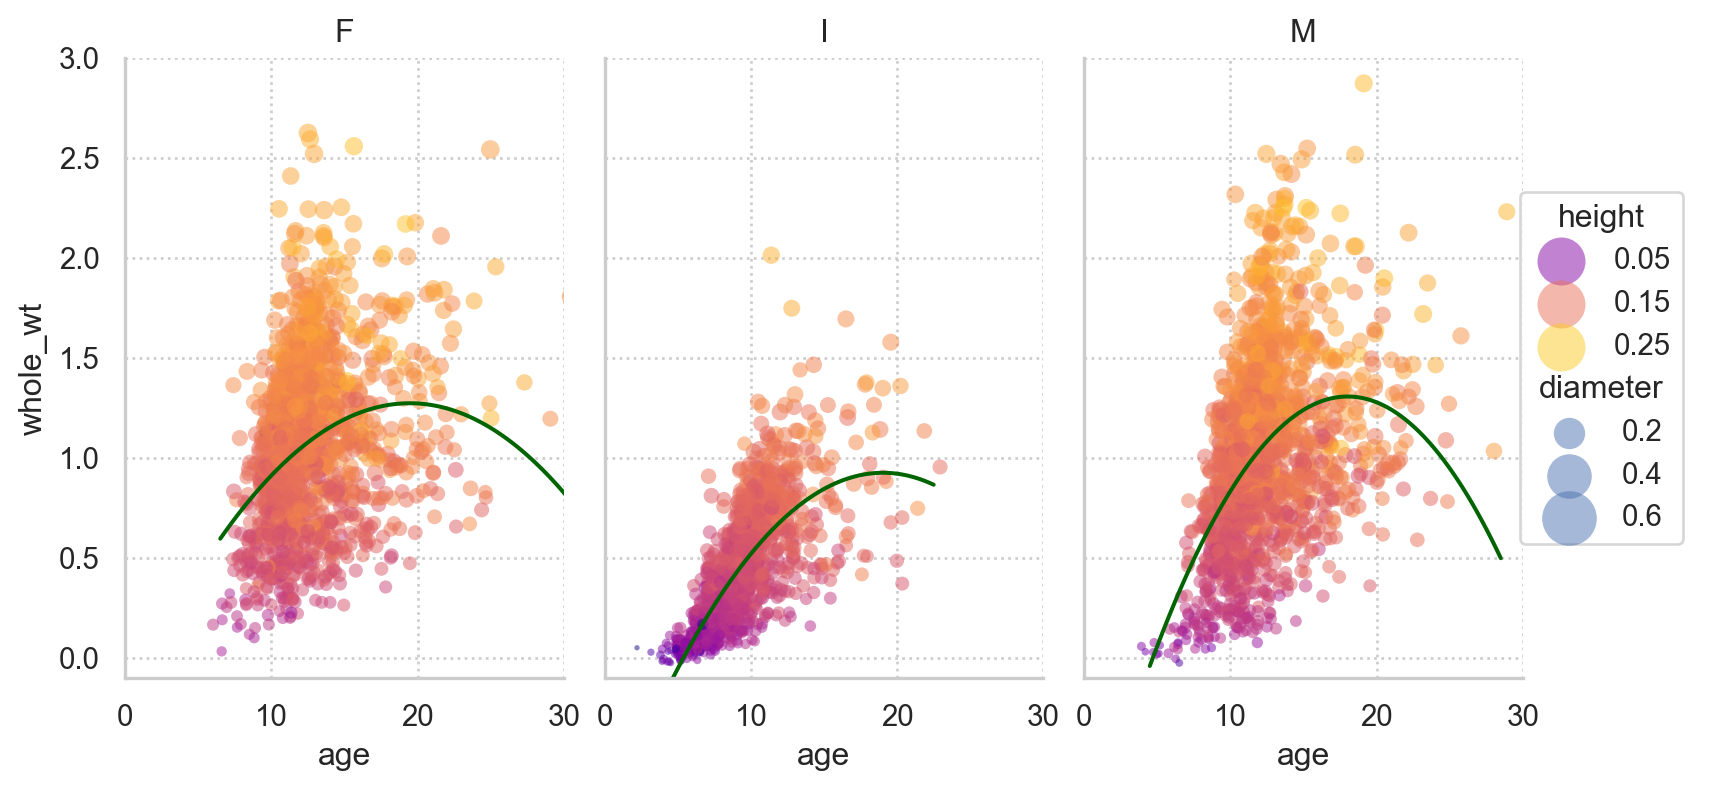

In [109]:
(so.Plot(abalone, 
         x='age', 
         y='whole_wt')
   .theme(rc_params)
   .facet(col='sex')
   .share(x=True)
   .layout(size=(8, 4), 
           engine='constrained')
   .add(so.Dot(alpha=0.5,
               edgewidth=0),
        so.Dodge(),
        so.Jitter(x=1, 
                  y=0.1),
        color='height',
        pointsize='diameter')
   .add(so.Line(color='darkgreen'),
        so.PolyFit())
   .scale(color=so.Continuous('plasma', 
                              norm=(0.01, 0.3), 
                              trans='sqrt'
                             ).tick(at=[0.05, 0.15, 0.25]),
          pointsize=(2, 7))
   .limit(x=[0, 30],
          y=[-0.1, 3]))

Comparing the data between sexes has shown that there's no big difference between male and female abalones rather than between either of them and infant specimen. It allows us to join `F` and `M` categories of `sex` to reduce dimensiality of the features.

In [110]:
abalone['infant'] = pd.Series(np.where(1, abalone['sex'] == 'I', 0), dtype='category')

## Can you estimate an abalone's age using its physical characteristics? 

Let's take `rings` as a target, because is coded as `int` and it has a simple linear relation with `age` (just add 1.5 to get `age`)

In [111]:
X = abalone.drop(columns=['age', 'rings', 'sex'])

y = abalone['rings']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2)

feature_names = X.columns

print(X_train.shape, X_test.shape, 
      y_train.shape, y_test.shape)

(3337, 8) (835, 8) (3337,) (835,)


In [112]:
subsets = {'test': (X_test, y_test),
           'original': (X, y)}

#### Keras Regression

In [113]:
# Categorical input layer
input_tensor_cat = Input(shape=(2,))

# Embedded flattened layer
embed_layer = Embedding(input_dim=len(X_train),
                        input_length=1,
                        output_dim=1,
                        name='sex_category')
embed_tensor = embed_layer(input_tensor_cat)
flatten_tensor = Flatten()(embed_tensor)

# Numerical input layer
input_tensor_num = Input(shape=(7,))


# Normalization layer
normalization_layer = Normalization(axis=None)(input_tensor_num)

# Combined input layer
comb_input = Concatenate()([flatten_tensor,
                            normalization_layer])
# Dense layers
hidden_layer = Dense(128, activation='relu')(comb_input)
hidden_layer = Dense(1024, activation='selu')(hidden_layer)
hidden_layer = Dense(32, activation='relu')(hidden_layer)
hidden_layer = Dense(64, activation='selu')(hidden_layer)

# Output layers
output_tensor = Concatenate()([comb_input, 
                               hidden_layer])
output_tensor = Dense(1)(output_tensor)

# Build the model
model = Model(inputs=[input_tensor_cat,
                      input_tensor_num],
              outputs=output_tensor)

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [114]:
# Summarize the model
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 sex_category (Embedding)       (None, 2, 1)         3337        ['input_9[0][0]']                
                                                                                                  
 input_10 (InputLayer)          [(None, 7)]          0           []                               
                                                                                                  
 flatten_4 (Flatten)            (None, 2)            0           ['sex_category[0][0]']           
                                                                                            

In [115]:
history = model.fit([to_categorical(X_train.infant),
                     X_train.select_dtypes(exclude='category')],
                    y_train,
                    epochs=1024,
                    batch_size=len(X_train)//32,
                    validation_split=0.1,
                    validation_data=[[to_categorical(X_test.infant),
                                      X_test.select_dtypes(exclude='category')],
                                     y_test],
                    verbose=False)

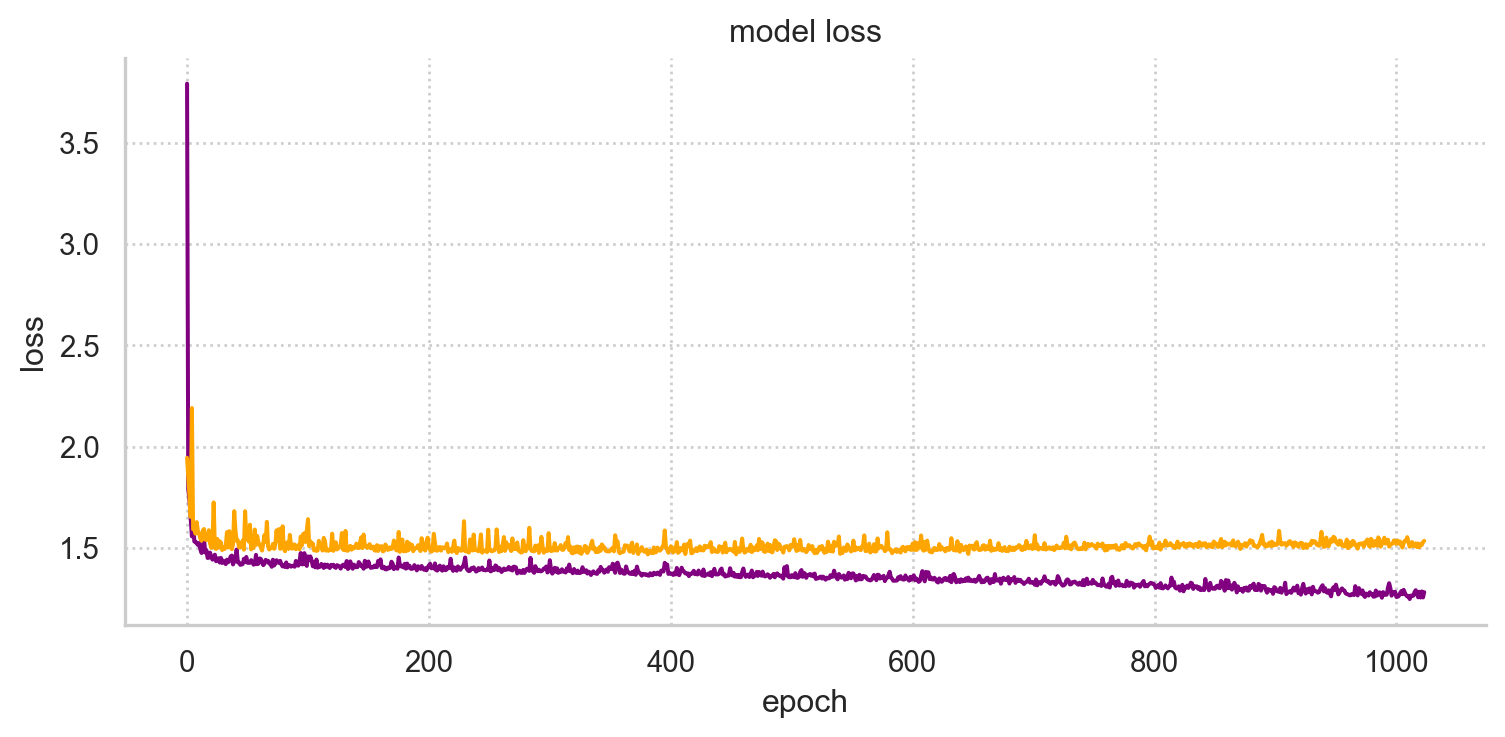

In [116]:
(so.Plot(pd.DataFrame(history.history),
         x=pd.DataFrame(history.history).index,
         y='loss')
   .layout(size=(8, 4))
   .theme(rc_params) 
   .add(so.Line(color='purple'),
        legend=True)
   .add(so.Line(color='orange'),
        x=pd.DataFrame(history.history).index,
        y='val_loss',
        legend=True)
   .label(x='epoch', 
          y='loss',
          color=['train', 'test'],
          title='model loss'))

test
loss 1.5351005792617798
r2_score: 0.49295843115197313 

original
loss 1.3069473505020142
r2_score: 0.6165510752119006 



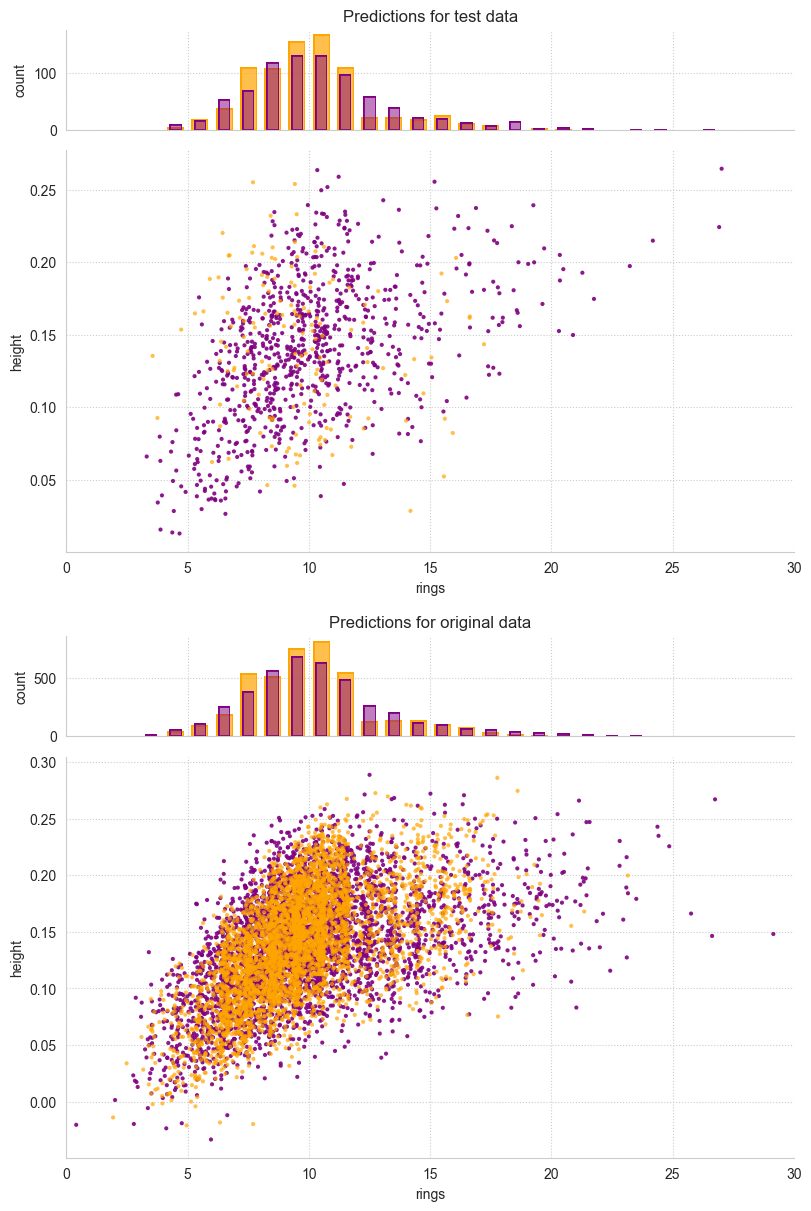

In [117]:
f = mpl.figure.Figure(figsize=(8, 12),
                      constrained_layout=True)

sfs = f.subfigures(2, 1)

for (subset, (features, target)), sf in zip(subsets.items(), sfs):
    
    loss = model.evaluate([to_categorical(features.infant),
                           features.select_dtypes(exclude='category')],
                          target,
                          verbose=False)
    
    pred = np.round(model.predict([to_categorical(features.infant),
                                   features.select_dtypes(exclude='category')],
                                  verbose=False))
    
    data = pd.DataFrame(features, columns=feature_names)
    axes = sf.subplots(2, 1,
                       sharex=True,
                       height_ratios=[0.5, 2])
    g1 = (so.Plot(data,
                  x=target)
            .theme(rc_params)
            .add(so.Bar(color='orange',
                        width=0.7), 
                 so.Hist(binwidth=1,
                         common_bins=True),
                 x=pred[:, 0])
            .add(so.Bar(color='purple',
                        width=0.5,
                        alpha=0.5), 
                 so.Hist(binwidth=1,
                         common_bins=True))
            .label(x=None,
                   y='count',
                   title=f'Predictions for {subset} data'))
    g2 = (so.Plot(data, 
                  x=target,
                  y='height') 
            .theme(rc_params)
            .add(so.Dot(color='purple', 
                        edgewidth=0, 
                        alpha=0.9,
                        pointsize=3), 
                 so.Jitter(x=loss, 
                           y=0.1))
            .add(so.Dot(color='orange', 
                        edgewidth=0, 
                        alpha=0.7,
                        pointsize=3), 
                 so.Jitter(x=loss, 
                           y=0.1),
                 x=pred[:, 0])
            .limit(x=[0, 30]))
    g1.on(axes[0]).plot()
    g2.on(axes[1]).plot()
    print(subset)
    print('loss', loss)
    print('r2_score:', r2_score(target, pred), '\n')
f

In [118]:
def make_results_df(features, target):
    pred = np.round(model.predict([to_categorical(features.infant),
                                   features.select_dtypes(exclude='category')],
                                  verbose=False)[:, 0].astype('int'))
    return pd.DataFrame({'true': target,
                         'predicted': pred,
                         'error': target-pred,
                         'absolute_error': np.abs(target-pred)})

In [119]:
for subset, (features, target) in subsets.items():
    print(f'{subset} data predictions:')
    display(make_results_df(features, target).sample(n=10))
    print('mean_absolute_error:', make_results_df(features, target).absolute_error.mean(), '\n')

test data predictions:


true  predicted  error  absolute_error
3702    11          9      2               2
2243     6          8     -2               2
531     13          8      5               5
1155     8          9     -1               1
3208    13         10      3               3
1241     8          6      2               2
499     10         13     -3               3
2204    27         18      9               9
4120     9          8      1               1
525      4          3      1               1

mean_absolute_error: 1.6395209580838324 

original data predictions:


true  predicted  error  absolute_error
3843    14         11      3               3
697      5          5      0               0
994      8          9     -1               1
2701    11         10      1               1
255     15         15      0               0
3429     6          6      0               0
1195     9          8      1               1
4090    11         10      1               1
3936    15         15      0               0
488     11          9      2               2

mean_absolute_error: 1.4108341323106424 



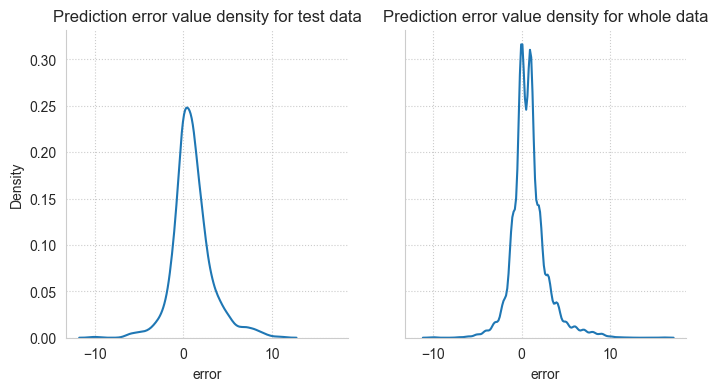

In [120]:
test_preds = make_results_df(X_test, y_test)
data_preds = make_results_df(X, y)

f = mpl.figure.Figure(figsize=(8, 4))
axes = f.subplots(1, 2,
                  sharex=True,
                  sharey=True)
sns.kdeplot(data=test_preds,
            x='error',
            ax=axes[0]).set_title('Prediction error value density for test data')
sns.kdeplot(data=data_preds,
            x='error',
            ax=axes[1]).set_title('Prediction error value density for whole data')
f

## Investigate which variables are better predictors of age for abalones.

model score on training data:  0.5494244615070254
model score on testing data:  0.5211825063942964


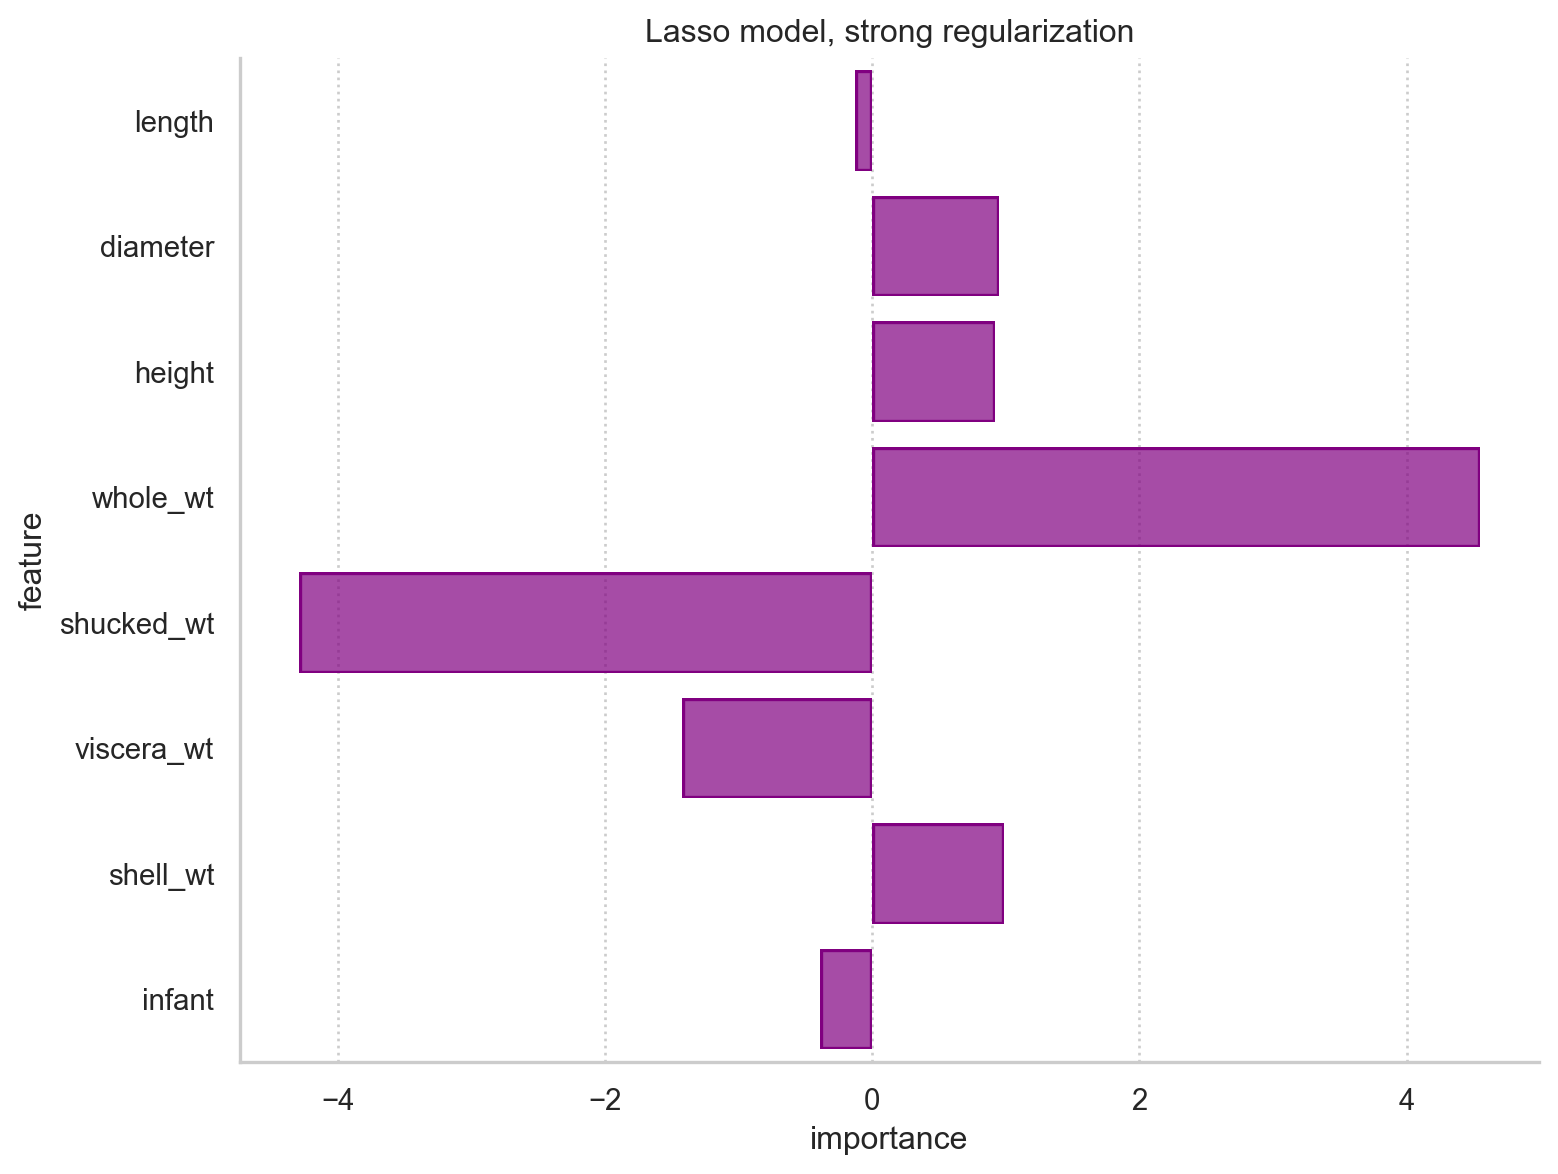

In [131]:
lasso = make_pipeline(StandardScaler(), 
                      Lasso(alpha=0.001))

lasso.fit(X_train, y_train)

print('model score on training data: ',
      f'{lasso.score(X_train.to_numpy(), y_train.to_numpy())}')
print('model score on testing data: ',
      f'{lasso.score(X_test.to_numpy(), y_test.to_numpy())}')
coefs = pd.DataFrame(lasso[1].coef_,
                     index=feature_names,
                     columns=['coefficients'])
(so.Plot(coefs,
         x='coefficients',
         y=coefs.index)
   .theme(rc_params)  
   .layout(size=(8, 6), 

           engine='constrained') 
   .add(so.Bar(color='purple'))
   .label(x='importance',
          y='feature',
          title='Lasso model, strong regularization'))

## Validation on synthetic data

In [122]:
abalone_xarray = abalone.drop(columns=['age', 'sex']).to_xarray()

In [123]:
# Create Generator    
generator = syn.CopulaDataGenerator(verbose=False)

# Define Coupla and Parameterizer    
ctrl = pv.FitControlsVinecop(family_set=[pv.gaussian], trunc_lvl=1, select_trunc_lvl=False)

generator.fit(abalone_xarray, types={'infant': 'cat'}, copula=syn.VineCopula(controls=ctrl))   

In [124]:
samples = generator.generate(n_samples=len(abalone)*4, uniformization_ratio=0, stretch_factor=1)

In [125]:
abalone_synth = pd.DataFrame(samples.to_array(), 
                             index=abalone.drop(columns=['age', 'sex']
                            ).columns.sort_values(ascending=True)
                            ).T[abalone.drop(columns=['age', 'sex']).columns
                               ].astype({'infant': 'category',
                                         'length': 'float64',
                                         'diameter': 'float64',
                                         'height': 'float64',
                                         'whole_wt': 'float64',
                                         'shucked_wt': 'float64',
                                         'viscera_wt': 'float64',
                                         'shell_wt': 'float64',
                                         'rings': 'int64'})
abalone_synth['age'] = abalone_synth['rings']+1.5
display(abalone_synth.sample(n=10))

length  diameter  height  whole_wt  shucked_wt  viscera_wt  shell_wt  \
14722    0.46      0.36    0.10      0.42        0.12        0.07      0.12   
16010    0.68      0.52    0.17      1.62        0.77        0.32      0.37   
8178     0.50      0.37    0.14      0.60        0.24        0.16      0.15   
15607    0.57      0.43    0.11      0.66        0.25        0.14      0.18   
10264    0.60      0.47    0.15      1.22        0.55        0.28      0.33   
9371     0.56      0.42    0.15      0.97        0.48        0.25      0.29   
11636    0.52      0.43    0.14      0.83        0.29        0.18      0.28   
2234     0.35      0.26    0.14      0.31        0.14        0.07      0.08   
5482     0.43      0.28    0.12      0.18        0.07        0.04      0.07   
12501    0.70      0.56    0.20      1.81        0.78        0.39      0.48   

       rings infant   age  
14722      6   1.00  7.50  
16010      9   0.00 10.50  
8178       8   1.00  9.50  
15607      9   1.00 10.50  
10264      7   0.00  8.50  
9371       9   0.00 10.50  
11636     20   0.00 21.50  
2234       8   1.00  9.50  
5482       6   1.00  7.50  
12501     10   0.00 11.50

In [126]:
X_synth = abalone_synth.drop(columns=['age', 'rings'])
y_synth = abalone_synth['rings']
print(X_synth.shape, y_synth.shape)

(16688, 8) (16688,)


synthetic
loss 2.2739031314849854
r2_score: 0.040690515385900516 



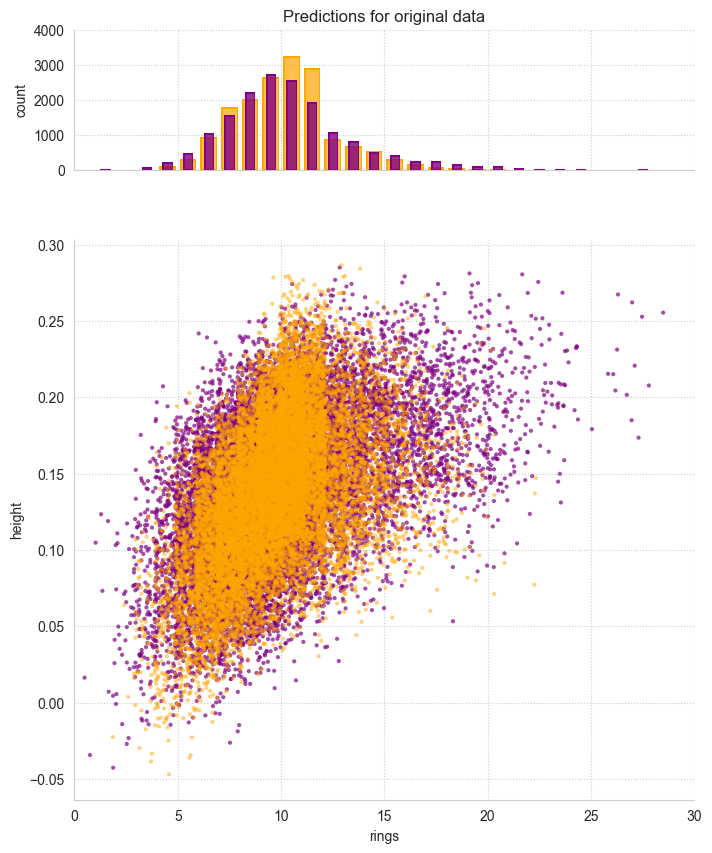

In [127]:
f = mpl.figure.Figure(figsize=(8, 10),
                      constrained_layout=True)
for _ in range(1):
    loss = model.evaluate([to_categorical(X_synth.infant),
                           X_synth.select_dtypes(exclude='category')],
                          y_synth,
                          verbose=False)
    
    pred = np.round(model.predict([to_categorical(X_synth.infant),
                                   X_synth.select_dtypes(exclude='category')],
                                  verbose=False))
    
    data = pd.DataFrame(X_synth, columns=feature_names)
    axes = f.subplots(2, 1,
                       sharex=True,
                       height_ratios=[0.5, 2])
    g1 = (so.Plot(data,
                  x=y_synth)
            .theme(rc_params)
            .add(so.Bar(color='orange',
                        width=0.8), 
                 so.Hist(binwidth=1,
                         common_bins=True),
                 x=pred[:, 0])
            .add(so.Bar(color='purple',
                        width=0.5,
                        alpha=0.8), 
                 so.Hist(binwidth=1,
                         common_bins=True))
            .limit(x=[0, 30],
                   y=[0, 4000])
            .label(x=None,
                   y='count',
                   title=f'Predictions for {subset} data'))
    g2 = (so.Plot(data, 
                  x=y_synth,
                  y='height')
            .theme(rc_params)
            .add(so.Dot(color='purple', 
                        edgewidth=0, 
                        alpha=0.7,
                        pointsize=3), 
                 so.Jitter(x=loss, 
                           y=0.1))
            .add(so.Dot(color='orange', 
                        edgewidth=0, 
                        alpha=0.5,
                        pointsize=3), 
                 so.Jitter(x=loss, 
                           y=0.1),
                 x=pred[:, 0])
            .limit(x=[0, 30]))
    g1.on(axes[0]).plot()
    g2.on(axes[1]).plot()
    
    print('synthetic')
    print('loss', loss)
    print('r2_score:', r2_score(y_synth, pred), '\n')

f

In [128]:
synth_preds = make_results_df(X_synth, y_synth)

f = mpl.figure.Figure(figsize=(8, 4))
axes = f.subplots(1, 1)
sns.kdeplot(data=synth_preds,
            x='error',
            ax=axes).set_title('Prediction error value density for synthetic data')
f

In [129]:
print(f'synthetic data predictions:')
display(synth_preds.sample(n=10))
print('mean_absolute_error:', synth_preds.absolute_error.mean(), '\n')

synthetic data predictions:


true  predicted  error  absolute_error
11804     9          9      0               0
13094     8          6      2               2
12086     6          8     -2               2
14741     6          6      0               0
6419     10         10      0               0
6443      5          6     -1               1
1633     10         10      0               0
7361     16         12      4               4
4848     12          9      3               3
6375     10          9      1               1

mean_absolute_error: 2.3382670182166825 

